### Ce notebook récupère les données de simulation du modèle depuis "launch_simu_ss.py" pour en faire des visualisations.

Fréquence du dernier mode de corde calculé : 11636 Hz
Fréquence du dernier mode de plaque calculé : 6310 Hz
Fréquence d'échantillonage : 8000 Hz
Temps d'acquisition : 10 s


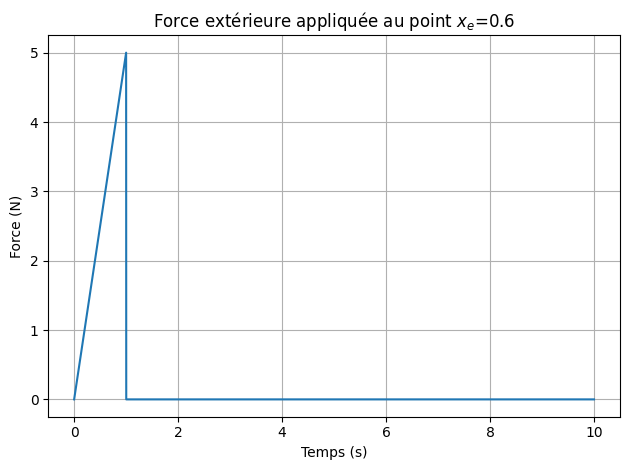

In [1]:
from guitare_config import *
from simu_config import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.rcParams["figure.figsize"] = (12,4)

# Simulation 

On compare aussi la méthode de vico (_ss) et la méthode de l'article (_ar). La méthode ss est plus robuste car elle fonctionne quelque soit Fe, mais moins rapide. La méthode de l'article fonctionne pour Fe=44100 mais pas diverge à bas Fe.

In [ ]:
#choix méthode : 
meth_article = False #la plus rapide, mais ne marche pas à bas Fe
meth_ss = True

In [ ]:
if meth_ss : 
    import launch_simu_ss

    Q_ss = launch_simu_ss.Q
    #Mouvement de la corde
    QS_ss = Q_ss[:NmS,:]
    QB_ss = Q_ss[NmS:,:]

#Passage dans les coordonnées cartésiennes
    simuS_NxS_Nt_ss = phiS_Nx_NmS @ QS_ss
    simuB_NxNy_Nt_ss = phiB_NxNy_NmB @ QB_ss

In [ ]:
if meth_article : 
    import launch_simu_article

    Q_ar = launch_simu_article.Q
    #Mouvement de la corde
    QS_ar = Q_ar[:NmS,:]
    QB_ar = Q_ar[NmS:,:]

    #Passage dans les coordonnées cartésiennes
    simuS_NxS_Nt_ar = phiS_Nx_NmS @ QS_ar
    simuB_NxNy_Nt_ar = phiB_NxNy_NmB @ QB_ar

In [ ]:
# visualisaiton
fig = plt.figure()
ax1 = fig.add_subplot(111)

if meth_article and not meth_ss:
    ax1.plot(t, simuS_NxS_Nt_ar[NxS//2,:],label="")
    ax1.set_title(rf"Evolution temporelle du point $x$={xS[NxS//2]:.2f} de la corde, méthode article")
if meth_ss and not meth_article: 
    ax1.plot(t, simuS_NxS_Nt_ss[NxS//2,:],label="")
    ax1.set_title(rf"Evolution temporelle du point $x$={xS[NxS//2]:.2f} de la corde,méthode Vico")
if meth_ss and meth_article :  ##si on a choisi les deux méthodes on plote la dif des deux 
    ax1.plot(t, simuS_NxS_Nt_ss[NxS//2,:] - simuS_NxS_Nt_ar[NxS//2,:],label="")
    ax1.set_title(rf"Evolution temporelle du point $x$={xS[NxS//2]:.2f} de la corde, différence des deux méthodes")

    
ax1.grid()
ax1.set_xlabel("Temps (s)")
ax1.set_ylabel("Déplacement (m)")
fig.tight_layout()
plt.show()

In [ ]:
Q = Q_ar
#Mouvement de la corde
QS = QS_ar
QB = QS_ar

#Passage dans les coordonnées cartésiennes
simuS_NxS_Nt = simuS_NxS_Nt_ar
simuB_NxNy_Nt = simuB_NxNy_Nt_ar

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

img = ax1.imshow(np.abs(simuB_NxNy_Nt_ar[:,int(1.5*Fe)]).reshape((Nx,Ny)),
    extent=[x[0], x[-1] , y[0], y[-1]] ,
    cmap="jet",
    interpolation = "bilinear",
    # aspect="auto" ,
    origin="lower")

fig.colorbar(img,ax=ax1)
ax1.set_xlabel("Longueur (m)")
ax1.set_ylabel(r"Largeur (m)")
ax1.set_title(rf"Profil vibratoire de la plaque à $t$={t[int(1.5*Fe)]:.1f} s")

fig.tight_layout()

plt.show()

# Ecoute

In [ ]:
if meth_ss :
    from IPython.display import display, Audio

    display(Audio(simuS_NxS_Nt_ss[500,:], rate=Fe))

In [ ]:
from IPython.display import display, Audio

display(Audio(simuS_NxS_Nt[500,:], rate=Fe))

# Exportation des GIFs

In [ ]:
#GIF CORDE
fe_anim = 15     #Hz

N_interval_anim = int(Fe/fe_anim)   #Nombre de points entre 0 et 1/fe_anim secondes

Ntanim = int(Nt/N_interval_anim)    #Nombre de points total de l'échantillonage visuel en fe_anim FPS
rms_Ntanim_NxS = np.zeros((Ntanim,NxS))
t_anim = np.zeros(Ntanim)
for i in range(Ntanim) :
    # rms_Ntanim_Nx[i,:] = np.sqrt(np.sum(np.square(xcorde_Nx_Nt[:,i*N_interval_anim:i*N_interval_anim+N_interval_anim-1]),axis=1))
    rms_Ntanim_NxS[i,:] = simuS_NxS_Nt[:,i*N_interval_anim]
    t_anim[i] = t[i*N_interval_anim]

rms_Nx_Ntanim = rms_Ntanim_NxS.T

fig = plt.figure(figsize=(13,6))
ax1 = fig.add_subplot(111)

line, = ax1.plot(xS,rms_Nx_Ntanim[:,0],label="")
ax1.grid()
# ax1.legend()
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y(x,t)$")
ax1.set_title(f"temps t={t_anim[0]}s")
ax1.set_ylim(np.min(rms_Nx_Ntanim),np.max(rms_Nx_Ntanim))

def init() :
    line.set_ydata(rms_Nx_Ntanim[:,0])
    line.set_xlim()
    ax1.set_title(f"temps t={t_anim[0]}s")
    return line,

def update(t_idx) :
    line.set_ydata(rms_Nx_Ntanim[:,t_idx])
    ax1.set_title(f"temps t={t_anim[t_idx]:.0f} s")
    return line,

import matplotlib.animation as animation

myAnimation = animation.FuncAnimation(fig, update, frames=Ntanim, interval=1/fe_anim, blit=True, repeat=False)
print("Done ✅")

myAnimation.save("figures/gif_corde.gif", writer='PillowWriter', fps=fe_anim)

In [ ]:
#GIF PLAQUE
fe_anim = 50     #Hz

N_interval_anim = int(Fe/fe_anim)   #Nombre de points entre 0 et 1/fe_anim secondes

Ntanim = int(2*Fe/N_interval_anim)    #Nombre de points total de l'échantillonage visuel en fe_anim FPS
rms_Ntanim_NxNy = np.zeros((Ntanim,Nx*Ny))
t_anim = np.zeros(Ntanim)
for i in range(Ntanim) :
    # rms_Ntanim_NxNy[i,:] = simuB_NxNy_Nt[:,i*N_interval_anim]
    rms_Ntanim_NxNy[i,:] = np.sqrt(np.sum(np.square(simuB_NxNy_Nt[:,i*N_interval_anim:i*N_interval_anim+N_interval_anim-1]),axis=1))
    t_anim[i] = t[i*N_interval_anim]

rms_NxNy_Ntanim = rms_Ntanim_NxNy.T

fig = plt.figure(figsize=(13,6))
ax1 = fig.add_subplot(111)

img = ax1.imshow(np.abs(rms_NxNy_Ntanim[:,0]).reshape((Nx,Ny)),
    extent=[x[0], x[-1] , y[0], y[-1]] ,
    cmap="jet" ,
    interpolation = "bilinear",
    aspect="auto" ,
    origin="lower")

fig.colorbar(img,ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel(r"")
ax1.set_title(r"")


def init() :
    img.set_data(np.abs(rms_NxNy_Ntanim[:,0]).reshape((Nx,Ny)))
    ax1.set_title(f"temps t={t_anim[0]}s")
    return [img]

def update(t_idx) :
    img.set_data(np.abs(rms_NxNy_Ntanim[:,t_idx]).reshape((Nx,Ny)))
    ax1.set_title(f"temps t={t_anim[t_idx]:.0f} s")
    img.set_clim([np.min(np.abs(rms_NxNy_Ntanim[:,:])),np.max(np.abs(rms_NxNy_Ntanim[:,:]))])
    return [img]

import matplotlib.animation as animation

myAnimation = animation.FuncAnimation(fig, update, frames=Ntanim, interval=1/fe_anim, blit=True, repeat=False)
print("Done ✅")

myAnimation.save("figures/gif_plaque.gif", writer='PillowWriter', fps=fe_anim/2)